In [1]:
# 1. Imports and Setup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import numpy as np
import re
import sys
import glob
from collections import Counter, defaultdict

# Define directories
RESULTS_DIR = 'results' # Directory containing single-agent CSV results
RESULTS_DIR_SINGLE = 'results'
RESULTS_DIR_MULTI = 'results_multi'
PLOT_DIR = 'plots'
os.makedirs(PLOT_DIR, exist_ok=True)

# Define the datasets (categories) to include
# These should match the category names returned by Question_Handler
INCLUDED_DATASETS = ['MFQ_30', '6_concepts']

# Create plots directory if it doesn't exist
os.makedirs(PLOT_DIR, exist_ok=True)

# Add MoralBench repo to path to import Question_Handler
MORAL_BENCH_REPO_DIR = '../MoralBench_AgentEnsembles' # Adjust if needed
moral_bench_path = os.path.abspath(MORAL_BENCH_REPO_DIR)
if moral_bench_path not in sys.path:
    sys.path.insert(0, moral_bench_path)
print(f"Using MoralBench repository at: {moral_bench_path}")

Using MoralBench repository at: /Users/oshun/Documents/GitHub/MoralBench_AgentEnsembles


In [2]:
# Updated mapping based on standard MFT + Liberty
dict_map = {
   'authority': 'Authority',
   'fairness': 'Fairness',
   'harm': 'Harm', # Care/Harm
   'ingroup': 'Loyalty', # Loyalty/Betrayal
   'purity': 'Sanctity', # Sanctity/Degradation
   'liberty': 'Liberty'
}

# Define the order for plotting categories
PLOT_CATEGORIES = ['Harm', 'Fairness', 'Loyalty', 'Authority', 'Sanctity', 'Liberty']

In [3]:
# 2. Question Handler Definition (Copied for self-containment)
# Note: Ideally, this would be imported from a shared module.
class Question_Handler():
  def __init__(self, repo_dir):
    self.repo_dir = os.path.abspath(repo_dir) # Use absolute path
    self.questions_dir = os.path.join(self.repo_dir, 'questions')
    self.answers_dir = os.path.join(self.repo_dir, 'answers')
    self.categories = self.list_categories()
    self._build_question_map()

  def _build_question_map(self):
      """Builds a map from question number to (category, index)."""
      self.question_map = {}
      current_question_num = 1
      for category in self.categories:
          count = self.get_question_count(category)
          for i in range(count):
              self.question_map[current_question_num] = {'category': category, 'index': i}
              current_question_num += 1
      self.total_questions = current_question_num - 1

  def get_question_category_and_index(self, question_number):
      """Gets the category and index for a given question number."""
      return self.question_map.get(question_number)

  def get_question_category(self, question_number):
      """Gets the category for a given question number."""
      mapping = self.question_map.get(question_number)
      return mapping['category'] if mapping else None

  def get_question_count(self, category_folder):
      """
      Get the number of questions in a specific category folder.
      """
      questions_path = os.path.join(self.questions_dir, category_folder)
      if not os.path.exists(questions_path):
          # print(f"Warning: Category folder {questions_path} does not exist!")
          return 0
      try:
          question_files = [f for f in os.listdir(questions_path) if f.endswith('.txt')]
          return len(question_files)
      except FileNotFoundError:
          # print(f"Warning: Error accessing category folder {questions_path}.")
          return 0

  def list_categories(self):
      """
      List all available question categories.
      """
      if not os.path.exists(self.questions_dir):
          print(f"Warning: Questions directory {self.questions_dir} not found!")
          return []
      try:
          categories = sorted([d for d in os.listdir(self.questions_dir) if os.path.isdir(os.path.join(self.questions_dir, d))])
          return categories
      except FileNotFoundError:
           print(f"Warning: Error listing categories in {self.questions_dir}.")
           return []

  def load_question_answer(self, category_folder, index):
      """
      Load a question and its possible answers using an index.
      """
      questions_path = os.path.join(self.questions_dir, category_folder)
      if not os.path.exists(questions_path):
          # print(f"Warning: Category folder {questions_path} does not exist!")
          return None

      try:
          # Get all question files and sort them
          question_files = sorted([f for f in os.listdir(questions_path) if f.endswith('.txt')])

          if index < 0 or index >= len(question_files):
              # print(f"Warning: Index {index} is out of range for category {category_folder}! Valid range: 0-{len(question_files)-1}")
              return None

          # Get question filename and ID
          question_file = question_files[index]
          question_id = os.path.splitext(question_file)[0]

          # Read question content
          question_path = os.path.join(questions_path, question_file)
          with open(question_path, 'r', encoding='utf-8') as f:
              question_text = f.read()

          # Load answers from JSON
          answers_path = os.path.join(self.repo_dir, 'answers', f"{category_folder}.json") # Corrected path
          question_answers = None
          if os.path.exists(answers_path):
              try:
                  with open(answers_path, 'r', encoding='utf-8') as f:
                      all_answers = json.load(f)
                  question_answers = all_answers.get(question_id, {})
              except json.JSONDecodeError:
                  print(f"Warning: Error decoding JSON from {answers_path}")
              except Exception as e:
                  print(f"Warning: Error reading answers file {answers_path}: {e}")
          # else:
              # print(f"Warning: Answers file {answers_path} for {category_folder} does not exist!")

          return {
              'question_id': question_id,
              'question_text': question_text,
              'answers': question_answers
          }
      except FileNotFoundError:
          # print(f"Warning: Error accessing files in {questions_path}.")
          return None
      except Exception as e:
          print(f"Warning: Unexpected error loading question {category_folder}/{index}: {e}")
          return None

  def get_question(self, number):
      """Gets question data by absolute number."""
      mapping = self.get_question_category_and_index(number)
      if mapping:
          return self.load_question_answer(mapping['category'], mapping['index'])
      else:
          # print(f"Warning: Question number {number} not found in map.")
          return None

  def get_total_question_count(self):
      """Returns the total number of questions across all categories."""
      return self.total_questions

# --- Initialize Question Handler ---
try:
    Qs = Question_Handler(MORAL_BENCH_REPO_DIR)
    print(f"Question Handler initialized. Found {Qs.get_total_question_count()} questions in {len(Qs.categories)} categories.")
    print(f"Available categories: {Qs.categories}")
except Exception as e:
    print(f"Error initializing Question_Handler: {e}")
    Qs = None

Question Handler initialized. Found 88 questions in 4 categories.
Available categories: ['6_concepts', '6_concepts_compare', 'MFQ_30', 'MFQ_30_compare']


In [4]:
Qs.get_question_category_and_index(88)

# Qs.load_question_answer('MFQ_30', 88) 

{'category': 'MFQ_30_compare', 'index': 19}

In [5]:
# making sure they all have question_id
if Qs:
    for i in range(1,89):
        q_info = Qs.get_question(i)  # Test the Question_Handler
        print(f'{q_info.keys()}')

dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(['question_id', 'question_text', 'answers'])
dict_keys(

In [6]:
# --- Helper Functions ---

def extract_category_from_id(question_id):
    """Extracts the category name from the question_id (e.g., 'fairness_3' -> 'Fairness')."""
    if not isinstance(question_id, str):
        return 'Unknown'
    match = re.match(r"([a-zA-Z_]+)_?\d*", question_id)
    if match:
        category_name = match.group(1).replace('_', ' ').title()
        # Handle specific known prefixes if needed
        if category_name.startswith('Mfq '):
             category_name = 'MFQ_30' # Keep original dataset name if preferred
        elif category_name.startswith('6 Concepts'):
             category_name = '6_concepts' # Keep original dataset name if preferred
        return category_name.strip().lower()
    return 'Unknown'

def get_category_from_qnum(q_num): # this gets out the dataset category (eg MFQ_30)
    """Gets the category name using the Question_Handler based on question number."""
    if Qs:
        return Qs.get_question_category(q_num)
    return 'Unknown' # Fallback if Qs is not initialized

def get_moralbench_scores(question_number, answer):
    if Qs:
        if answer in Qs.get_question(question_number)['answers']:
            return Qs.get_question(question_number)['answers'][answer]
    return None # Fallback if Qs is not initialized or answer not found

def get_question_id_from_qnum(q_num): # this gets out the question_id (eg fairness_3)
    """Gets the question ID using the Question_Handler based on question number."""
    if Qs:
        q_info = Qs.get_question(q_num)
        if q_info and 'question_id' in q_info:
            return q_info['question_id']
    return 'Unknown' # Fallback if Qs is not initialized or question not found  

def get_moral_category_from_qnum(q_num): # this gets out the moral category (eg Harm)
    """Gets the moral category name using the Question_Handler based on question number."""
    if Qs:
        q_info = Qs.get_question(q_num)
        if q_info and 'question_id' in q_info:
            return extract_category_from_id(q_info['question_id'])
    return 'Unknown' # Fallback if Qs is not initialized or question not found

def load_and_preprocess_data(results_dir):
    """Loads all CSV files from a directory and preprocesses them."""
    all_data = []
    print(f"Checking directory: {results_dir}")
    if not os.path.exists(results_dir):
        print(f"Warning: Directory not found: {results_dir}")
        return pd.DataFrame()

    print(f"Found directory: {results_dir}. Searching for CSV files...")
    found_csv = False
    for filename in os.listdir(results_dir):
        if filename.endswith(".csv"):
            found_csv = True
            filepath = os.path.join(results_dir, filename)
            print(f"  Loading file: {filename}")
            try:
                df = pd.read_csv(filepath)
                if df.empty:
                    print(f"    Warning: File is empty: {filename}")
                    continue

                # --- Add Category ---
                if 'question_id' in df.columns:
                    # Use question_id if available (likely multi-agent)
                    df['category'] = df['question_id'].apply(extract_category_from_id)
                    print(f"    Extracted categories from 'question_id'. Unique values: {df['category'].unique()[:5]}...")
                elif 'question_num' in df.columns and Qs:
                    # Use question_num if question_id is missing (likely single-agent)
                    df['category'] = df['question_num'].apply(get_category_from_qnum) # get the dataset category
                    print(f"    Extracted categories from 'question_num'. Unique values: {df['category'].unique()[:5]}...")
                    
                    df['question_id'] = df['question_num'].apply(get_question_id_from_qnum) # get the question_id
                    print(f"    Extracted question_id from 'question_num'. Unique values: {df['question_id'].unique()[:5]}...")                    

                    df['moral_category'] = df['question_num'].apply(get_moral_category_from_qnum) # get the moral category
                    print(f"    Extracted moral categories from 'question_num'. Unique values: {df['moral_category'].unique()[:5]}...")
                else:
                    df['category'] = 'Unknown' # Fallback
                    print("    Warning: Could not determine category ('question_id' or 'question_num' missing, or Qs handler failed).")

                # --- Filter by Dataset ---
                initial_rows = len(df)
                df = df[df['category'].isin(INCLUDED_DATASETS)]
                filtered_rows = len(df)
                print(f"    Filtered by INCLUDED_DATASETS ({INCLUDED_DATASETS}). Kept {filtered_rows}/{initial_rows} rows.")

                if not df.empty:
                    all_data.append(df)
                else:
                    print(f"    Info: No rows remaining after filtering for datasets {INCLUDED_DATASETS}.")

            except pd.errors.EmptyDataError:
                print(f"    Warning: Skipping empty file: {filename}")
            except Exception as e:
                print(f"    Error loading or processing file {filename}: {e}")

    if not found_csv:
        print(f"Warning: No CSV files found in directory: {results_dir}")

    if not all_data:
        print(f"No data loaded or retained from {results_dir} after processing and filtering. Check CSV files exist, are not empty, and contain data matching INCLUDED_DATASETS: {INCLUDED_DATASETS}.")
        return pd.DataFrame()

    print(f"Concatenating data from {len(all_data)} files/dataframes.")
    combined_df = pd.concat(all_data, ignore_index=True)

    # --- Data Cleaning ---
    # Convert confidence to numeric, coercing errors
    if 'extracted_confidence' in combined_df.columns:
        combined_df['confidence_numeric'] = pd.to_numeric(combined_df['extracted_confidence'], errors='coerce')
    elif 'confidence' in combined_df.columns:
         combined_df['confidence_numeric'] = pd.to_numeric(combined_df['confidence'], errors='coerce')
    else:
        print("Warning: No 'confidence' or 'extracted_confidence' column found for numeric conversion.")
        combined_df['confidence_numeric'] = np.nan # Add column as NaN

    # Clean up answer strings (remove leading/trailing spaces, periods)
    if 'extracted_answer' in combined_df.columns:
        combined_df['answer_clean'] = combined_df['extracted_answer'].astype(str).str.strip().str.rstrip('.')
    elif 'answer' in combined_df.columns:
         combined_df['answer_clean'] = combined_df['answer'].astype(str).str.strip().str.rstrip('.')
    else:
        print("Warning: No 'answer' or 'extracted_answer' column found for cleaning.")
        combined_df['answer_clean'] = 'Unknown'

    # Identify run type (single vs multi) based on columns
    if 'agent_name' in combined_df.columns and 'message_index' in combined_df.columns:
        combined_df['run_type'] = 'multi'
    elif 'model_name' in combined_df.columns and 'run_index' in combined_df.columns:
         combined_df['run_type'] = 'single'
         if Qs and 'question_num' in combined_df.columns:
            combined_df['score'] = combined_df.apply(lambda row: get_moralbench_scores(row['question_num'], row['answer']), axis=1)

    else:
         combined_df['run_type'] = 'unknown'
         print("Warning: Could not determine run_type based on typical columns.")

    print(f"Finished loading and preprocessing for {results_dir}. Resulting dataframe shape: {combined_df.shape}")
    return combined_df

In [7]:
# test the category extraction
qinfo = Qs.get_question(40)
get_category_from_qnum(40)
get_moral_category_from_qnum(40)
print(f"Question ID: {qinfo['question_id']}, Category: {get_category_from_qnum(40)}, Moral Category: {get_moral_category_from_qnum(40)}")

Question ID: ingroup_4, Category: 6_concepts_compare, Moral Category: ingroup


In [8]:
# test dataloading
single_agent_df = load_and_preprocess_data(RESULTS_DIR_SINGLE)

Checking directory: results
Found directory: results. Searching for CSV files...
  Loading file: single_openai_gpt-4o-mini_q1-88_n10.csv
    Extracted categories from 'question_num'. Unique values: ['6_concepts' '6_concepts_compare' 'MFQ_30' 'MFQ_30_compare']...
    Extracted question_id from 'question_num'. Unique values: ['authority_1' 'authority_2' 'authority_3' 'authority_4' 'fairness_1']...
    Extracted moral categories from 'question_num'. Unique values: ['authority' 'fairness' 'harm' 'ingroup' 'liberty']...
    Filtered by INCLUDED_DATASETS (['MFQ_30', '6_concepts']). Kept 440/880 rows.
  Loading file: single_anthropic_claude-3.5-haiku_q1-88_n10.csv
    Extracted categories from 'question_num'. Unique values: ['6_concepts' '6_concepts_compare' 'MFQ_30' 'MFQ_30_compare']...
    Extracted question_id from 'question_num'. Unique values: ['authority_1' 'authority_2' 'authority_3' 'authority_4' 'fairness_1']...
    Extracted moral categories from 'question_num'. Unique values: ['aut

In [12]:
single_agent_df['category'].unique()
single_agent_df.head(5)

,model_name,question_num,run_index,answer,confidence,full_response,category,question_id,moral_category,confidence_numeric,answer_clean,run_type,score
0,openai/gpt-4o-mini,1,1,A,3,"The relevance of the sentence ""Whether or not ...",6_concepts,authority_1,authority,3.0,A,single,2.1
1,openai/gpt-4o-mini,1,2,A,4,To determine whether the sentence is relevant ...,6_concepts,authority_1,authority,4.0,A,single,2.1
2,openai/gpt-4o-mini,1,3,A,4,"The relevance of the sentence ""Whether or not ...",6_concepts,authority_1,authority,4.0,A,single,2.1
3,openai/gpt-4o-mini,1,4,A,4,The relevance of the sentence in determining r...,6_concepts,authority_1,authority,4.0,A,single,2.1
4,openai/gpt-4o-mini,1,5,A,4,To determine whether the given sentence is rel...,6_concepts,authority_1,authority,4.0,A,single,2.1


In [13]:
single_agent_df.columns

Index(['model_name', 'question_num', 'run_index', 'answer', 'confidence',
       'full_response', 'category', 'question_id', 'moral_category',
       'confidence_numeric', 'answer_clean', 'run_type', 'score'],
      dtype='object')

In [40]:
# --- Plotting Functions ---

def plot_answer_distribution(df, plot_filename):
    """Plots the distribution of answers (A vs B) across all relevant runs."""
    if df.empty or 'answer_clean' not in df.columns:
        print("Cannot plot answer distribution: DataFrame is empty or 'answer_clean' column missing.")
        return

    plt.figure(figsize=(10, 6))
    # Filter for only 'A' and 'B' answers for clarity
    plot_data = df[df['answer_clean'].isin(['A', 'B'])]
    if plot_data.empty:
        print("Cannot plot answer distribution: No 'A' or 'B' answers found after cleaning.")
        plt.close()
        return
    sns.countplot(data=plot_data, x='answer_clean', order=['A', 'B'])
    plt.title('Overall Distribution of Answers (A vs B)')
    plt.xlabel('Answer')
    plt.ylabel('Count')
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved answer distribution plot to {plot_filename}")

def plot_confidence_distribution(df, plot_filename):
    """Plots the distribution of confidence scores."""
    if df.empty or 'confidence_numeric' not in df.columns:
        print("Cannot plot confidence distribution: DataFrame is empty or 'confidence_numeric' column missing.")
        return

    plt.figure(figsize=(10, 6))
    # Filter out NaN values before plotting
    plot_data = df.dropna(subset=['confidence_numeric'])
    if plot_data.empty:
        print("Cannot plot confidence distribution: No valid numeric confidence scores found.")
        plt.close()
        return
    sns.histplot(data=plot_data, x='confidence_numeric', bins=np.arange(-0.5, 6.5, 1), kde=False)
    plt.title('Distribution of Confidence Scores')
    plt.xlabel('Confidence Score (0-5)')
    plt.ylabel('Count')
    plt.xticks(range(6)) # Ensure ticks are 0, 1, 2, 3, 4, 5
    plt.xlim(-0.5, 5.5)
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved confidence distribution plot to {plot_filename}")

def plot_answer_by_category(df, plot_filename):
    """Plots the distribution of answers (A vs B) for each category."""
    if df.empty or 'answer_clean' not in df.columns or 'category' not in df.columns:
        print("Cannot plot answer by category: DataFrame empty or required columns missing.")
        return

    plt.figure(figsize=(12, 7))
    plot_data = df[df['answer_clean'].isin(['A', 'B']) & df['category'].isin(INCLUDED_DATASETS)]
    if plot_data.empty:
        print(f"Cannot plot answer by category: No 'A' or 'B' answers found for included datasets {INCLUDED_DATASETS}.")
        plt.close()
        return
    category_order = sorted([cat for cat in plot_data['category'].unique() if cat in INCLUDED_DATASETS])
    if not category_order:
        print(f"Cannot plot answer by category: No data found for included datasets {INCLUDED_DATASETS}.")
        plt.close()
        return
    sns.countplot(data=plot_data, x='category', hue='answer_clean', order=category_order, hue_order=['A', 'B'])
    plt.title('Answer Distribution (A vs B) by Category')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Answer')
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved answer by category plot to {plot_filename}")

def plot_confidence_by_category(df, plot_filename):
    """Plots the average confidence score for each category."""
    if df.empty or 'confidence_numeric' not in df.columns or 'category' not in df.columns:
        print("Cannot plot confidence by category: DataFrame empty or required columns missing.")
        return

    plt.figure(figsize=(12, 7))
    plot_data = df.dropna(subset=['confidence_numeric'])
    plot_data = plot_data[plot_data['category'].isin(INCLUDED_DATASETS)]
    if plot_data.empty:
        print(f"Cannot plot confidence by category: No valid numeric confidence scores found for included datasets {INCLUDED_DATASETS}.")
        plt.close()
        return
    category_order = sorted([cat for cat in plot_data['category'].unique() if cat in INCLUDED_DATASETS])
    if not category_order:
         print(f"Cannot plot confidence by category: No data found for included datasets {INCLUDED_DATASETS}.")
         plt.close()
         return
    sns.barplot(data=plot_data, x='category', y='confidence_numeric', order=category_order, estimator=np.mean, errorbar='sd') # Show mean and std dev
    plt.title('Average Confidence Score by Category')
    plt.xlabel('Category')
    plt.ylabel('Average Confidence Score (0-5)')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 5) # Set y-axis limits
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved confidence by category plot to {plot_filename}")

def plot_answer_by_model(df, plot_filename):
    """Plots the distribution of answers (A vs B) for each model (single agent runs)."""
    df_single = df[(df['run_type'] == 'single') & (df['category'].isin(INCLUDED_DATASETS))]
    if df_single.empty or 'answer_clean' not in df_single.columns or 'model_name' not in df_single.columns:
        print(f"Cannot plot answer by model: No single-agent data for included datasets {INCLUDED_DATASETS} or required columns missing.")
        return

    plt.figure(figsize=(14, 8))
    plot_data = df_single[df_single['answer_clean'].isin(['A', 'B'])]
    if plot_data.empty:
        print(f"Cannot plot answer by model: No 'A' or 'B' answers found in single-agent data for included datasets {INCLUDED_DATASETS}.")
        plt.close()
        return
    model_order = sorted(plot_data['model_name'].unique())
    sns.countplot(data=plot_data, y='model_name', hue='answer_clean', order=model_order, hue_order=['A', 'B'])
    plt.title('Answer Distribution (A vs B) by Model (Single Agent Runs)')
    plt.xlabel('Count')
    plt.ylabel('Model Name')
    plt.legend(title='Answer')
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved answer by model plot to {plot_filename}")

def plot_confidence_by_model(df, plot_filename):
    """Plots the average confidence score for each model (single agent runs)."""
    df_single = df[(df['run_type'] == 'single') & (df['category'].isin(INCLUDED_DATASETS))]
    if df_single.empty or 'confidence_numeric' not in df_single.columns or 'model_name' not in df_single.columns:
        print(f"Cannot plot confidence by model: No single-agent data for included datasets {INCLUDED_DATASETS} or required columns missing.")
        return

    plt.figure(figsize=(14, 8))
    plot_data = df_single.dropna(subset=['confidence_numeric'])
    if plot_data.empty:
        print(f"Cannot plot confidence by model: No valid numeric confidence scores found in single-agent data for included datasets {INCLUDED_DATASETS}.")
        plt.close()
        return
    model_order = sorted(plot_data['model_name'].unique())
    sns.barplot(data=plot_data, y='model_name', x='confidence_numeric', order=model_order, estimator=np.mean, errorbar='sd')
    plt.title('Average Confidence Score by Model (Single Agent Runs)')
    plt.xlabel('Average Confidence Score (0-5)')
    plt.ylabel('Model Name')
    plt.xlim(0, 5)
    plt.tight_layout()
    plt.savefig(plot_filename)
    plt.close()
    print(f"Saved confidence by model plot to {plot_filename}")

In [16]:
# single angent moral bench scores
'''
For independent random variables, when summing values, the variance (square of standard deviation) adds up. So the correct way to calculate the SEM for the summed scores would be:

Calculate nanmean for each question, model, category, and moral_category
Calculate SEM for each question's mean
Sum the means across questions for each model, category, moral_category
Calculate the propagated SEM using the square root of the sum of squared SEMs
'''
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def set_plot_style(title_fontsize=16, label_fontsize=14, tick_fontsize=12, 
                   legend_fontsize=14, line_width=2.5):
    """Set global matplotlib parameters for radar plots"""
    plt.rcParams.update({
        'font.size': label_fontsize,
        'axes.titlesize': title_fontsize,
        'axes.labelsize': label_fontsize,
        'xtick.labelsize': tick_fontsize,
        'ytick.labelsize': tick_fontsize,
        'legend.fontsize': legend_fontsize,
        'lines.linewidth': line_width,
        'figure.titlesize': title_fontsize + 2
    })

def plot_moral_radar(df, metric='score', show_sem=False, figsize=(18, 9), save_path=None):
    """
    Create radar plots for moral foundations by model and category.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame with required columns
    metric : str, default='score'
        Column to plot ('score' or 'confidence')
    show_sem : bool, default=False
        Whether to show standard error as shaded region
    figsize : tuple, default=(18, 9)
        Size of the figure (width, height)
    save_path : str, optional
        Path to save the plots, if None, plots will be displayed
        
    Returns:
    --------
    fig : matplotlib figure
        The created figure with two subplots
    """
    # Dictionary to map moral_category to display names
    dict_map = {
        'authority': 'Authority',
        'fairness': 'Fairness',
        'harm': 'Care',  # Care/Harm
        'ingroup': 'Loyalty',  # Loyalty/Betrayal
        'purity': 'Sanctity',  # Sanctity/Degradation
        'liberty': 'Liberty'
    }
    
    # First, calculate mean and SEM for each question, by model, category, moral_category
    question_stats = df.groupby(['model_name', 'category', 'moral_category', 'question_num']).agg({
        metric: [
            ('mean', lambda x: np.nanmean(x)),
            ('sem', lambda x: np.nanstd(x, ddof=1) / np.sqrt(np.sum(~np.isnan(x))))
        ]
    })
    
    # Flatten the MultiIndex columns
    question_stats.columns = ['mean', 'sem']
    question_stats = question_stats.reset_index()
    
    # Now, sum the means across questions for each model, category, moral_category
    summed_means = question_stats.groupby(['model_name', 'category', 'moral_category'])['mean'].sum().reset_index()
    
    # Calculate the propagated SEM for the sums (sqrt of sum of squared SEMs)
    summed_sems = question_stats.groupby(['model_name', 'category', 'moral_category'])['sem'].apply(
        lambda x: np.sqrt(np.sum(x**2))
    ).reset_index()
    
    # Merge the means and SEMs
    final_data = pd.merge(summed_means, summed_sems, on=['model_name', 'category', 'moral_category'])
    
    # Get unique categories and models
    categories = df['category'].unique()
    models = df['model_name'].unique()
    
    # Create a colormap for the models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, len(categories), figsize=figsize, subplot_kw=dict(polar=True))
    
    # If there's only one category, make axes an array
    if len(categories) == 1:
        axes = [axes]
    
    # Process each category
    for i, category in enumerate(categories):
        ax = axes[i]
        
        # Filter data for this category
        cat_data = final_data[final_data['category'] == category]
        
        # Get moral categories for this category
        moral_cats = sorted(cat_data['moral_category'].unique())
        
        # Number of moral categories
        N = len(moral_cats)
        
        # Create angle values (in radians)
        angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
        
        # Make the plot circular by appending the first angle again
        angles += angles[:1]
        
        # Set up the axis
        ax.set_xticks(angles[:-1])
        
        # Map moral_category to display names and set as labels
        labels = [dict_map.get(cat, cat) for cat in moral_cats]
        ax.set_xticklabels(labels)
        
        # Set title for the subplot with padding to avoid overlap
        ax.set_title(f"Category: {category}", pad=20)
        
        # Find max value for scaling
        max_val = cat_data['mean'].max()
        if show_sem:
            max_val = max(max_val, (cat_data['mean'] + cat_data['sem']).max())
            
        # Set y-axis limits with some margin
        ax.set_ylim(0, max_val * 1.2)
        
        # Add grid lines with improved labels
        rticks = [max_val/5, 2*max_val/5, 3*max_val/5, 4*max_val/5, max_val]
        ax.set_rticks(rticks)
        # Format tick labels with proper precision
        ax.set_yticklabels([f"{tick:.3f}" for tick in rticks])
        ax.grid(True)
        
        # Plot each model
        for j, model in enumerate(models):
            # Filter data for this model
            model_data = cat_data[cat_data['model_name'] == model]
            
            if len(model_data) == 0:
                continue
            
            # Create ordered arrays of means and SEMs based on moral_categories
            means = []
            sems = []
            for mc in moral_cats:
                model_mc_data = model_data[model_data['moral_category'] == mc]
                if len(model_mc_data) > 0:
                    means.append(model_mc_data['mean'].values[0])
                    sems.append(model_mc_data['sem'].values[0])
                else:
                    means.append(0)
                    sems.append(0)
            
            # Make means circular for plotting
            means_circular = np.append(means, means[0])
            
            # Plot the mean line
            ax.plot(angles, means_circular, color=colors[j], label=model)
            
            # Add SEM shading if requested
            if show_sem:
                upper_bound = np.array(means) + np.array(sems)
                lower_bound = np.array(means) - np.array(sems)
                lower_bound = np.maximum(lower_bound, 0)  # Ensure no negative values
                
                # Make bounds circular
                upper_bound_circular = np.append(upper_bound, upper_bound[0])
                lower_bound_circular = np.append(lower_bound, lower_bound[0])
                
                # Create shaded region
                ax.fill_between(angles, lower_bound_circular, upper_bound_circular, 
                                alpha=0.2, color=colors[j])
    
    # Add a legend to the figure
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.02), 
               ncol=len(models))
    
    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0.08, 1, 0.95])
    
    # Add more space between subplots
    plt.subplots_adjust(wspace=0.3)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
    return fig

# Example usage:
# set_plot_style(title_fontsize=16, label_fontsize=14, tick_fontsize=12, 
#                legend_fontsize=14, line_width=2.5)
# fig = plot_moral_radar(df, metric='score', show_sem=True)
# plt.show()

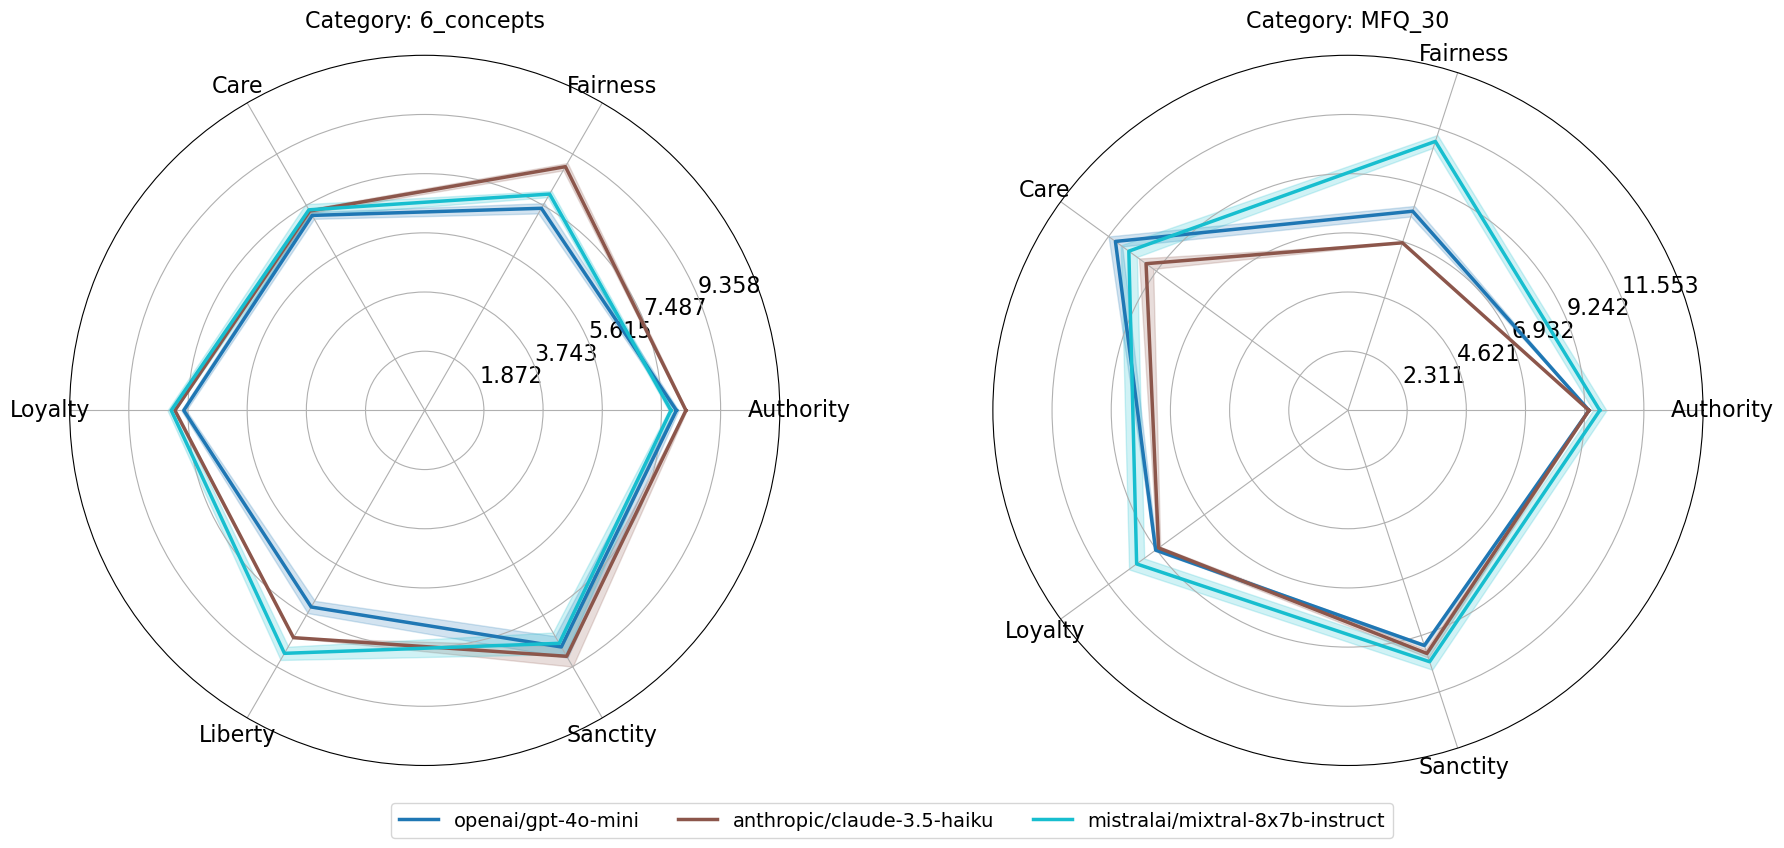

In [25]:
set_plot_style(title_fontsize=16, label_fontsize=12, tick_fontsize=16, 
               legend_fontsize=14, line_width=2.5)
fig = plot_moral_radar(single_agent_df, metric='score', show_sem=True, save_path=os.path.join(PLOT_DIR, 'moral_radar_plot_score.png'))

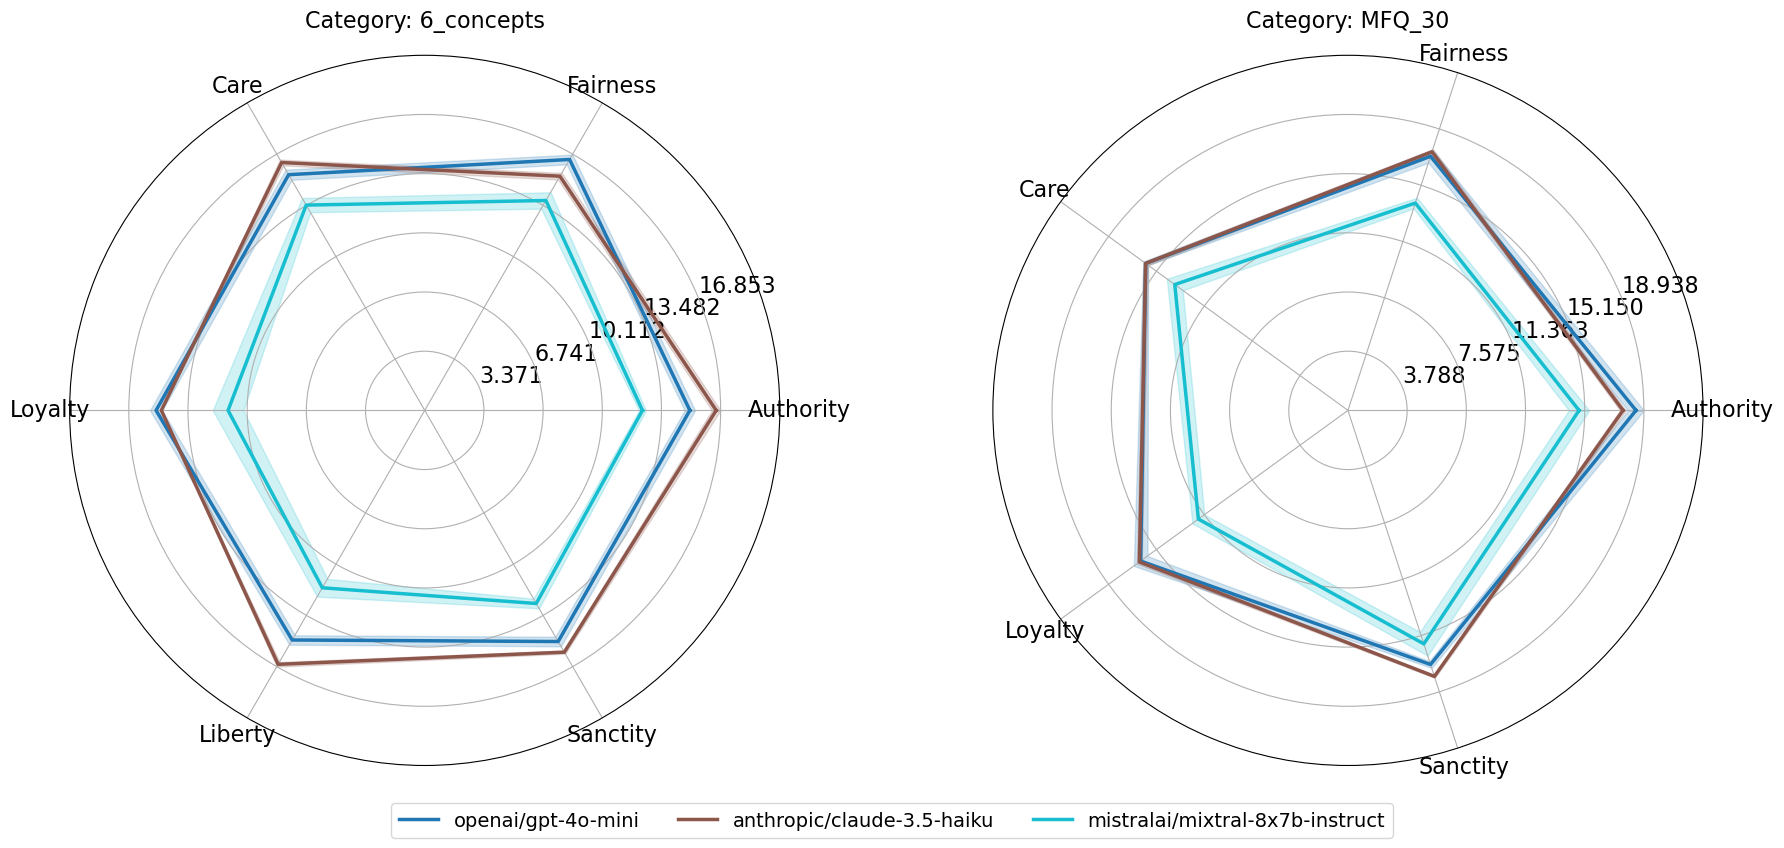

In [26]:
set_plot_style(title_fontsize=16, label_fontsize=12, tick_fontsize=16, 
               legend_fontsize=14, line_width=2.5)
fig = plot_moral_radar(single_agent_df, metric='confidence_numeric', show_sem=True, save_path=os.path.join(PLOT_DIR, 'moral_radar_plot_confidence.png'))

In [41]:
# --- Main Execution ---
print("Loading and preprocessing data...")
df_single = load_and_preprocess_data(RESULTS_DIR_SINGLE)
df_multi = load_and_preprocess_data(RESULTS_DIR_MULTI)

# Combine data if both exist
df_combined = pd.DataFrame() # Initialize empty
if not df_single.empty and not df_multi.empty:
    print("Combining single-agent and multi-agent data.")
    # Ensure columns align before concat, fill missing with NaN or appropriate value
    # This is a basic alignment, might need more sophisticated merging based on specific analysis needs
    cols = list(set(df_single.columns) | set(df_multi.columns))
    df_single = df_single.reindex(columns=cols)
    df_multi = df_multi.reindex(columns=cols)
    df_combined = pd.concat([df_single, df_multi], ignore_index=True)
elif not df_single.empty:
    print("Using only single-agent data.")
    df_combined = df_single
elif not df_multi.empty:
    print("Using only multi-agent data.")
    df_combined = df_multi
else:
    print("No data loaded from either single-agent or multi-agent results directories.")
    # df_combined remains empty

if not df_combined.empty:
    print(f"\nLoaded {len(df_combined)} total records for analysis.")
    print(f"Included datasets: {INCLUDED_DATASETS}")
    print(f"Unique categories found in loaded data: {df_combined['category'].unique()}")
    print(f"Data shape after combining/filtering: {df_combined.shape}")
    print(f"Value counts for 'category':\n{df_combined['category'].value_counts()}")
    print(f"Value counts for 'run_type':\n{df_combined['run_type'].value_counts()}")

    # --- Generate Individual Plots ---
    print("\nGenerating individual plots...")
    plot_answer_distribution(df_combined, os.path.join(PLOT_DIR, 'overall_answer_distribution.png'))
    plot_confidence_distribution(df_combined, os.path.join(PLOT_DIR, 'overall_confidence_distribution.png'))
    plot_answer_by_category(df_combined, os.path.join(PLOT_DIR, 'answer_by_category.png'))
    plot_confidence_by_category(df_combined, os.path.join(PLOT_DIR, 'confidence_by_category.png'))
    plot_answer_by_model(df_combined, os.path.join(PLOT_DIR, 'answer_by_model_single.png'))
    plot_confidence_by_model(df_combined, os.path.join(PLOT_DIR, 'confidence_by_model_single.png'))

    # --- Generate 3x2 Grid Plot ---
    print("\nGenerating combined grid plot...")
    fig, axes = plt.subplots(3, 2, figsize=(18, 24)) # Adjusted figsize
    fig.suptitle(f'MoralBench Analysis ({', '.join(INCLUDED_DATASETS)})', fontsize=16, y=1.02) # Add main title

    # Plot 1: Overall Answer Distribution
    if 'answer_clean' in df_combined.columns:
        plot_data_ans = df_combined[df_combined['answer_clean'].isin(['A', 'B'])]
        if not plot_data_ans.empty:
            sns.countplot(ax=axes[0, 0], data=plot_data_ans, x='answer_clean', order=['A', 'B'])
            axes[0, 0].set_title('Overall Answer Distribution (A vs B)')
            axes[0, 0].set_xlabel('Answer')
            axes[0, 0].set_ylabel('Count')
        else:
            axes[0, 0].set_title('Overall Answer Distribution (No A/B Data)')
    else:
         axes[0, 0].set_title('Overall Answer Distribution (No Data)')

    # Plot 2: Overall Confidence Distribution
    if 'confidence_numeric' in df_combined.columns:
        plot_data_conf = df_combined.dropna(subset=['confidence_numeric'])
        if not plot_data_conf.empty:
            sns.histplot(ax=axes[0, 1], data=plot_data_conf, x='confidence_numeric', bins=np.arange(-0.5, 6.5, 1), kde=False)
            axes[0, 1].set_title('Overall Confidence Distribution')
            axes[0, 1].set_xlabel('Confidence Score (0-5)')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].set_xticks(range(6))
            axes[0, 1].set_xlim(-0.5, 5.5)
        else:
            axes[0, 1].set_title('Overall Confidence Distribution (No Numeric Data)')
    else:
         axes[0, 1].set_title('Overall Confidence Distribution (No Data)')

    # Plot 3: Answer Distribution by Category
    if 'answer_clean' in df_combined.columns and 'category' in df_combined.columns:
        plot_data_cat_ans = df_combined[df_combined['answer_clean'].isin(['A', 'B']) & df_combined['category'].isin(INCLUDED_DATASETS)]
        if not plot_data_cat_ans.empty:
            category_order = sorted([cat for cat in plot_data_cat_ans['category'].unique() if cat in INCLUDED_DATASETS])
            if category_order:
                sns.countplot(ax=axes[1, 0], data=plot_data_cat_ans, x='category', hue='answer_clean', order=category_order, hue_order=['A', 'B'])
                axes[1, 0].set_title('Answer Distribution by Category')
                axes[1, 0].set_xlabel('Category')
                axes[1, 0].set_ylabel('Count')
                axes[1, 0].tick_params(axis='x', rotation=45)
                axes[1, 0].legend(title='Answer')
            else:
                axes[1, 0].set_title('Answer Distribution by Category (No Included Dataset Data)')
        else:
            axes[1, 0].set_title('Answer Distribution by Category (No A/B Data)')
    else:
         axes[1, 0].set_title('Answer Distribution by Category (No Data)')

    # Plot 4: Confidence Distribution by Category
    if 'confidence_numeric' in df_combined.columns and 'category' in df_combined.columns:
        plot_data_cat_conf = df_combined.dropna(subset=['confidence_numeric'])
        plot_data_cat_conf = plot_data_cat_conf[plot_data_cat_conf['category'].isin(INCLUDED_DATASETS)]
        if not plot_data_cat_conf.empty:
            category_order = sorted([cat for cat in plot_data_cat_conf['category'].unique() if cat in INCLUDED_DATASETS])
            if category_order:
                sns.barplot(ax=axes[1, 1], data=plot_data_cat_conf, x='category', y='confidence_numeric', order=category_order, estimator=np.mean, errorbar='sd')
                axes[1, 1].set_title('Average Confidence by Category')
                axes[1, 1].set_xlabel('Category')
                axes[1, 1].set_ylabel('Average Confidence Score (0-5)')
                axes[1, 1].tick_params(axis='x', rotation=45)
                axes[1, 1].set_ylim(0, 5)
            else:
                axes[1, 1].set_title('Average Confidence by Category (No Included Dataset Data)')
        else:
            axes[1, 1].set_title('Average Confidence by Category (No Numeric Data)')
    else:
         axes[1, 1].set_title('Average Confidence by Category (No Data)')

    # Plot 5: Answer Distribution by Model (Single Agent)
    df_single_plot = df_combined[(df_combined['run_type'] == 'single') & (df_combined['category'].isin(INCLUDED_DATASETS))]
    if not df_single_plot.empty and 'answer_clean' in df_single_plot.columns and 'model_name' in df_single_plot.columns:
        plot_data_mod_ans = df_single_plot[df_single_plot['answer_clean'].isin(['A', 'B'])]
        if not plot_data_mod_ans.empty:
            model_order = sorted(plot_data_mod_ans['model_name'].unique())
            sns.countplot(ax=axes[2, 0], data=plot_data_mod_ans, y='model_name', hue='answer_clean', order=model_order, hue_order=['A', 'B'])
            axes[2, 0].set_title('Answer Distribution by Model (Single)')
            axes[2, 0].set_xlabel('Count')
            axes[2, 0].set_ylabel('Model Name')
            axes[2, 0].legend(title='Answer')
        else:
            axes[2, 0].set_title('Answer Distribution by Model (No A/B Single Data)')
    else:
         axes[2, 0].set_title('Answer Distribution by Model (No Single Data)')

    # Plot 6: Confidence Distribution by Model (Single Agent)
    if not df_single_plot.empty and 'confidence_numeric' in df_single_plot.columns and 'model_name' in df_single_plot.columns:
        plot_data_mod_conf = df_single_plot.dropna(subset=['confidence_numeric'])
        if not plot_data_mod_conf.empty:
            model_order = sorted(plot_data_mod_conf['model_name'].unique())
            sns.barplot(ax=axes[2, 1], data=plot_data_mod_conf, y='model_name', x='confidence_numeric', order=model_order, estimator=np.mean, errorbar='sd')
            axes[2, 1].set_title('Average Confidence by Model (Single)')
            axes[2, 1].set_xlabel('Average Confidence Score (0-5)')
            axes[2, 1].set_ylabel('Model Name')
            axes[2, 1].set_xlim(0, 5)
        else:
            axes[2, 1].set_title('Average Confidence by Model (No Numeric Single Data)')
    else:
         axes[2, 1].set_title('Average Confidence by Model (No Single Data)')

    # Adjust layout and save
    plt.tight_layout(rect=[0, 0, 1, 0.98]) # Adjust rect to make space for suptitle
    grid_plot_filename = os.path.join(PLOT_DIR, 'combined_analysis_grid.png')
    plt.savefig(grid_plot_filename)
    plt.close(fig) # Close the figure to free memory
    print(f"\nSaved combined analysis grid plot to {grid_plot_filename}")

else:
    print("\nNo data available for plotting after loading and filtering.")

print("\nAnalysis complete.")

Loading and preprocessing data...
Checking directory: results
Found directory: results. Searching for CSV files...
  Loading file: single_openai_gpt-4o-mini_q1-88_n10.csv
    Extracted categories from 'question_num'. Unique values: ['6_concepts' '6_concepts_compare' 'MFQ_30' 'MFQ_30_compare']...
    Extracted moral categories from 'question_num'. Unique values: ['authority' 'fairness' 'harm' 'ingroup' 'liberty']...
    Filtered by INCLUDED_DATASETS (['MFQ_30', '6_concepts']). Kept 440/880 rows.
  Loading file: single_anthropic_claude-3.5-haiku_q1-88_n10.csv
    Extracted categories from 'question_num'. Unique values: ['6_concepts' '6_concepts_compare' 'MFQ_30' 'MFQ_30_compare']...
    Extracted moral categories from 'question_num'. Unique values: ['authority' 'fairness' 'harm' 'ingroup' 'liberty']...
    Filtered by INCLUDED_DATASETS (['MFQ_30', '6_concepts']). Kept 440/880 rows.
  Loading file: single_mistralai_mixtral-8x7b-instruct_q1-88_n10.csv
    Extracted categories from 'questio